In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
from tqdm import tqdm
from pathlib import Path
from uco.data_loader import pivot_df

In [18]:
df = pd.read_csv('../data/raw/sample_submission.csv')
print(df.shape[0])
df.head(20)

14792


,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1
1,002f507.jpg_Flower,1 1
2,002f507.jpg_Gravel,1 1
3,002f507.jpg_Sugar,1 1
4,0035ae9.jpg_Fish,1 1
5,0035ae9.jpg_Flower,1 1
6,0035ae9.jpg_Gravel,1 1
7,0035ae9.jpg_Sugar,1 1
8,0038327.jpg_Fish,1 1
9,0038327.jpg_Flower,1 1


In [4]:
H = 350
W = 525
C = 4
N = 3698

In [44]:
with h5py.File('../data/predictions/raw-predictions.h5', 'r') as f:
    for k in f.keys():
        print(k)
        # p = f[k][0, :, :, :] / 100
        # print(p.shape)

1030-114931
1030-174519


In [6]:
def read(f):
    path = Path('../data/raw/test_images') / f
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

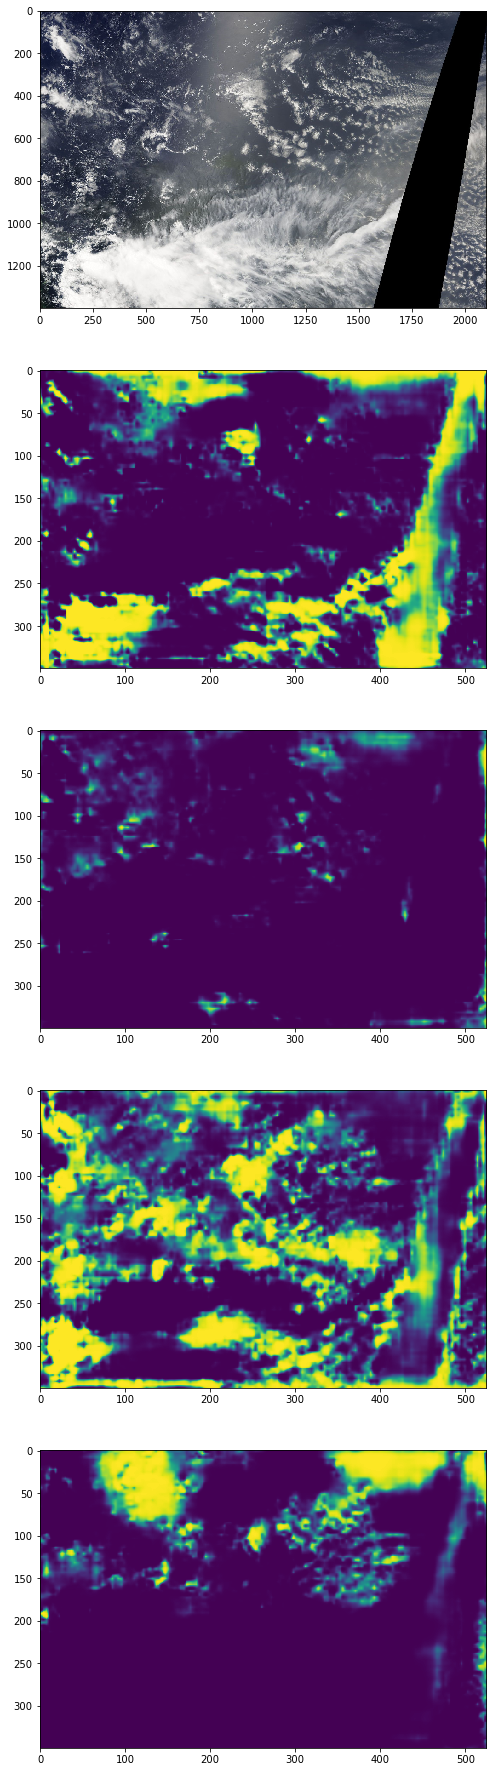

In [49]:
idx = 189
with h5py.File('../data/predictions/raw-predictions.h5', 'r') as f:
    p = f['1030-114931'][idx, :, :, :]
img_filename = df.iloc[idx * 4]['Image_Label'].split('_')[0]
img = read(img_filename)
fig, axs = plt.subplots(5, 1, figsize=(8, 32))
axs[0].imshow(img)
axs[1].imshow(p[0, :, :])
axs[2].imshow(p[1, :, :])
axs[3].imshow(p[2, :, :])
axs[4].imshow(p[3, :, :])
plt.show()

In [43]:
p[2, :, :].mean()

0.8300725

In [5]:
?experiments

In [17]:
preds.shape

(5, 4, 350, 525)

In [18]:
preds

array([[[[67, 77, 57, ..., 17,  4, 20],
         [98, 54, 58, ...,  5, 38,  0],
         [28, 92, 60, ..., 65, 61, 12],
         ...,
         [75, 17,  9, ..., 47, 84, 82],
         [27, 26, 60, ..., 72, 34, 71],
         [40, 29, 56, ...,  0, 31, 39]],

        [[85, 85, 17, ..., 38, 69, 76],
         [67, 27, 74, ..., 88, 86, 36],
         [21,  2, 47, ..., 65, 73, 94],
         ...,
         [16, 32, 89, ..., 24, 42, 53],
         [72, 76,  3, ..., 55,  2, 67],
         [ 5, 39, 57, ...,  4, 18, 41]],

        [[ 6, 38, 30, ..., 51, 84,  8],
         [87, 75, 11, ...,  4, 84, 72],
         [27, 11, 71, ..., 11, 64, 26],
         ...,
         [38,  3, 94, ..., 70, 32, 64],
         [23, 15, 30, ..., 84, 86, 63],
         [20, 79, 77, ..., 45, 94,  2]],

        [[48,  8, 42, ..., 79, 11, 83],
         [46, 40, 38, ..., 49,  9, 25],
         [34, 46, 35, ..., 95, 36, 18],
         ...,
         [53, 80,  8, ..., 42, 78, 53],
         [31, 64, 31, ..., 42, 87, 38],
         [95, 30, 

In [7]:
len(experiments)

TypeError: Not a location id (invalid object ID)